In [1]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt # for making figures
import json
import requests
%matplotlib inline

In [2]:
url = 'https://parseapi.back4app.com/classes/NamesList?limit=30000&keys=Name'
headers = {
    'X-Parse-Application-Id': 'zsSkPsDYTc2hmphLjjs9hz2Q3EXmnSxUyXnouj1I',
    'X-Parse-Master-Key': '4LuCXgPPXXO2sU5cXm6WwpwzaKyZpo3Wpj4G4xXK'
}
data = json.loads(requests.get(url, headers=headers).content.decode('utf-8'))

results = data['results']
names = [entry['Name'].lower().strip() for entry in results]

In [3]:
len(names)

6779

In [4]:
# Build vocabulary
chars = sorted(set(''.join(names)))
stoi = {ch: i+1 for i, ch in enumerate(chars)}
stoi['.'] = 0
itos = {i: ch for ch, i in stoi.items()}
print(itos)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}


In [5]:
# Encode dataset
block_size = 3
X, Y = [], []
for name in names:
    context = [0] * block_size  # padding
    for ch in name + '.':
        ix = stoi[ch]
        X.append(context.copy())
        Y.append(ix)
        context = context[1:] + [ix]
X = torch.tensor(X)
Y = torch.tensor(Y)


In [6]:
X.shape, X.dtype, Y.shape, Y.dtype

(torch.Size([46971, 3]), torch.int64, torch.Size([46971]), torch.int64)

In [7]:
# Build the dataset
block_size = 3

def build_dataset(names):  
  X, Y = [], []
  for name in names:
    context = [0] * block_size
    for ch in name + '.':
      ix = stoi[ch]
      X.append(context)
      Y.append(ix)
      context = context[1:] + [ix]

  X = torch.tensor(X)
  Y = torch.tensor(Y)
  print(X.shape, Y.shape)
  return X, Y

import random
random.seed(42)
random.shuffle(names)
n1 = int(0.8*len(names))
n2 = int(0.9*len(names))

Xtr, Ytr = build_dataset(names[:n1])
Xdev, Ydev = build_dataset(names[n1:n2])
Xte, Yte = build_dataset(names[n2:])

torch.Size([37597, 3]) torch.Size([37597])
torch.Size([4663, 3]) torch.Size([4663])
torch.Size([4711, 3]) torch.Size([4711])


In [8]:
Xtr.shape, Ytr.shape

(torch.Size([37597, 3]), torch.Size([37597]))

In [9]:
g = torch.Generator().manual_seed(234123)
C = torch.randn((27, 10), generator=g)
W1 = torch.randn((30, 200), generator=g)
b1 = torch.randn(200, generator=g)
W2 = torch.randn((200, 27), generator=g)
b2 = torch.randn(27, generator=g)
parameters = [C, W1, b1, W2, b2]

In [10]:
sum(p.nelement() for p in parameters)

11897

In [11]:
for p in parameters:
  p.requires_grad = True

In [12]:
lre = torch.linspace(-3, 0, 1000)
lrs = 10**lre
lri = []
lossi = []
stepi = []

In [13]:
for i in range(200000):
  
  # minibatch construct
  ix = torch.randint(0, Xtr.shape[0], (32,))
  
  # forward pass
  emb = C[Xtr[ix]]
  h = torch.tanh(emb.view(-1, 30) @ W1 + b1)
  logits = h @ W2 + b2
  loss = F.cross_entropy(logits, Ytr[ix])
  
  # backward pass
  for p in parameters:
    p.grad = None
  loss.backward()
  
  # update
  lr = 0.1 if i < 100000 else 0.01
  for p in parameters:
    p.data += -lr * p.grad

  stepi.append(i)
  lossi.append(loss.log10().item())

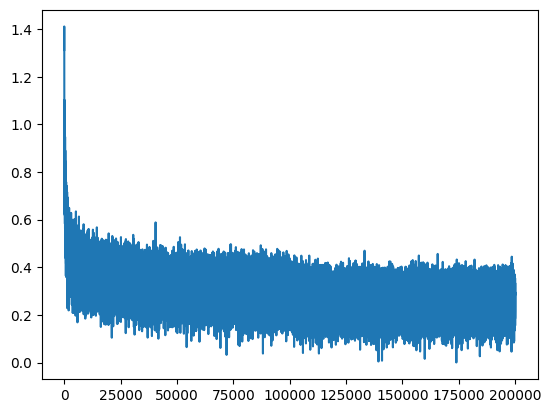

In [14]:
plt.plot(stepi, lossi)

In [15]:
emb = C[Xtr]
h = torch.tanh(emb.view(-1, 30) @ W1 + b1)
logits = h @ W2 + b2
loss = F.cross_entropy(logits, Ytr)
loss

tensor(1.8344, grad_fn=<NllLossBackward0>)

In [16]:
emb = C[Xdev] 
h = torch.tanh(emb.view(-1, 30) @ W1 + b1)
logits = h @ W2 + b2
loss = F.cross_entropy(logits, Ydev)
loss

tensor(2.1854, grad_fn=<NllLossBackward0>)

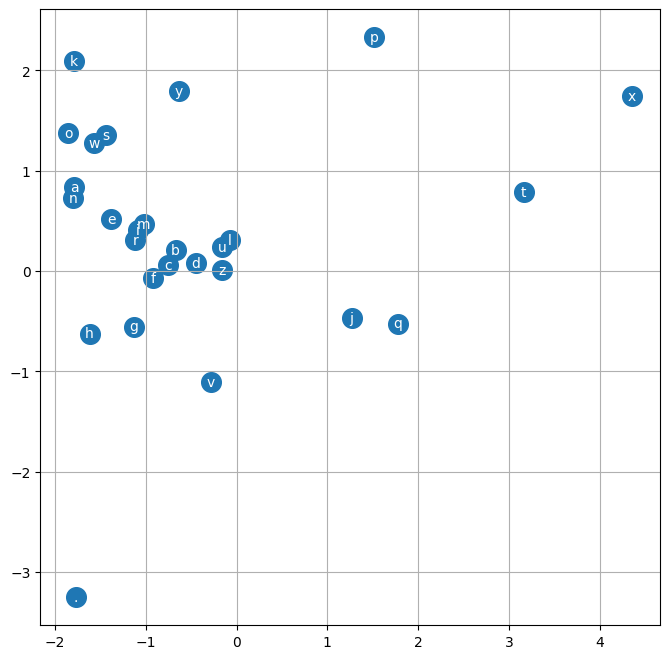

In [17]:
plt.figure(figsize=(8,8))
plt.scatter(C[:,0].data, C[:,1].data, s=200)
for i in range(C.shape[0]):
    plt.text(C[i,0].item(), C[i,1].item(), itos[i], ha="center", va="center", color='white')
plt.grid('minor')

In [18]:
context = [0] * block_size
C[torch.tensor([context])].shape

torch.Size([1, 3, 10])

In [19]:
g = torch.Generator().manual_seed(2147483647 + 10)

for _ in range(20):
    
    out = []
    context = [0] * block_size
    while True:
      emb = C[torch.tensor([context])]
      h = torch.tanh(emb.view(1, -1) @ W1 + b1)
      logits = h @ W2 + b2
      probs = F.softmax(logits, dim=1)
      ix = torch.multinomial(probs, num_samples=1, generator=g).item()
      context = context[1:] + [ix]
      out.append(ix)
      if ix == 0:
        break
    
    print(''.join(itos[i] for i in out))

mon.
camya.
hiles.
nichima.
tetus.
jendra.
gradelyn.
eline.
miloparete.
sustanardell.
colly.
amnyshabell.
hille.
tricke.
jeliquel.
octo.
benned.
rugedni.
eli.
kay.


## Part 3: Activations & Gradients, BatchNorm

In this section, we will:
1. Fix the initialization of weights to get a better starting loss.
2. Fix the saturation of `tanh` activations using Kaiming initialization.
3. Implement Batch Normalization.

Expected initial loss: 3.2958
Actual initial loss: 18.6417


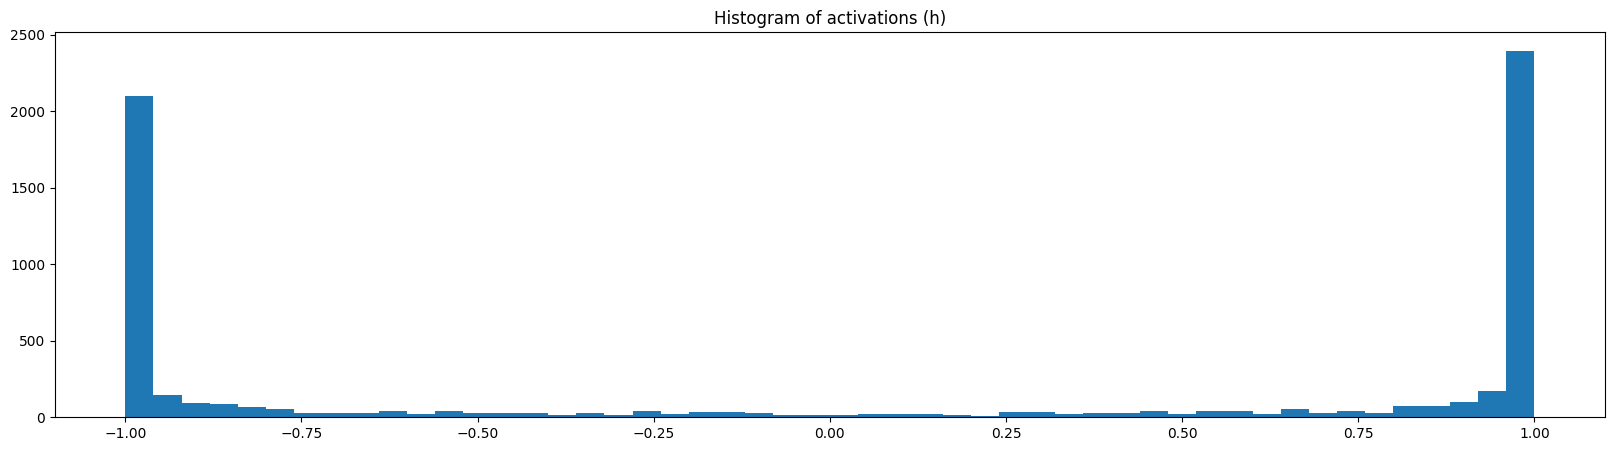

In [20]:
# 1. Initial Loss Analysis
# Expected loss for uniform probability is -log(1/27)
expected_loss = -torch.tensor(1/27).log()
print(f"Expected initial loss: {expected_loss.item():.4f}")

# Re-initialize parameters (standard random)
g = torch.Generator().manual_seed(2147483647)
C = torch.randn((27, 10), generator=g)
W1 = torch.randn((30, 200), generator=g)
b1 = torch.randn(200, generator=g)
W2 = torch.randn((200, 27), generator=g)
b2 = torch.randn(27, generator=g)
parameters = [C, W1, b1, W2, b2]
for p in parameters: p.requires_grad = True

# Forward pass
ix = torch.randint(0, Xtr.shape[0], (32,))
emb = C[Xtr[ix]]
h = torch.tanh(emb.view(-1, 30) @ W1 + b1)
logits = h @ W2 + b2
loss = F.cross_entropy(logits, Ytr[ix])
print(f"Actual initial loss: {loss.item():.4f}")

# Visualize the activations (h)
plt.figure(figsize=(20,5))
plt.hist(h.view(-1).tolist(), 50);
plt.title('Histogram of activations (h)');
plt.show()
# Notice the peaks at -1 and 1? That's tanh saturation. Gradients will be zero there.

### Fixing Initialization
1. **Fixing Initial Loss**: We want the logits to be roughly equal at initialization, so the loss starts at `-log(1/27)`. We can achieve this by scaling down `W2` and setting `b2` to zero.
2. **Fixing Tanh Saturation**: We use "Kaiming Initialization" (or He Initialization) for `W1`. For `tanh`, we scale weights by `gain / sqrt(fan_in)`, where `gain` is `5/3`.

New initial loss: 3.3072


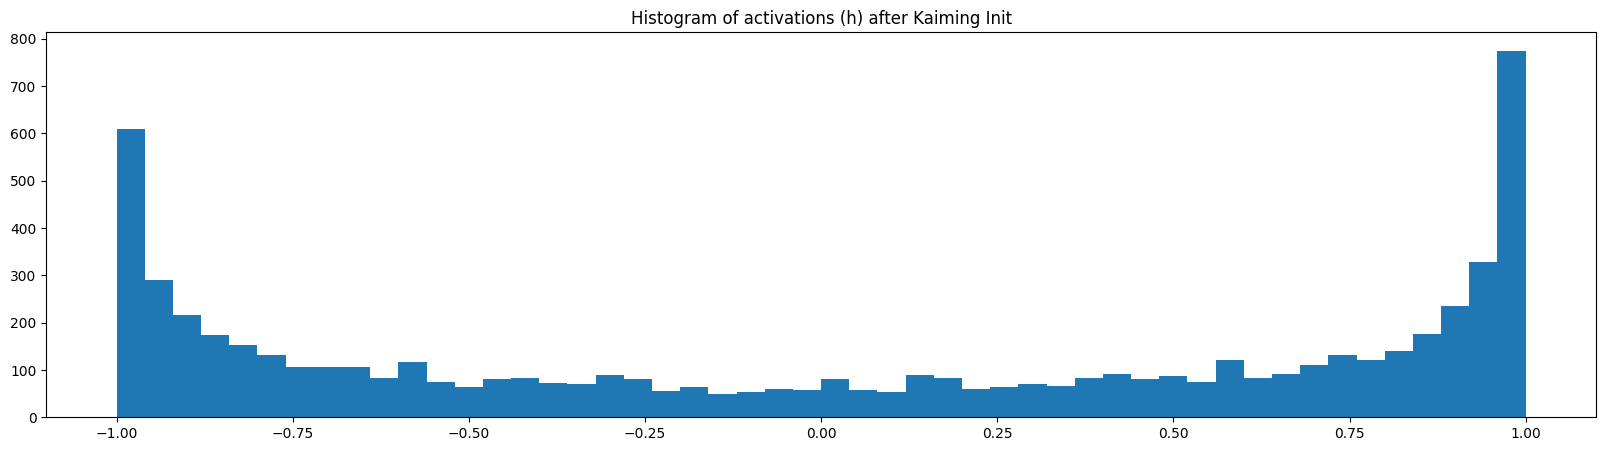

In [21]:
# Re-initialize with fixes
g = torch.Generator().manual_seed(2147483647)
C = torch.randn((27, 10), generator=g)

# Kaiming Init for W1 (fan_in = 30, gain = 5/3)
W1 = torch.randn((30, 200), generator=g) * (5/3) / ((30)**0.5) 
b1 = torch.randn(200, generator=g) * 0.01 # Small bias

# Scale W2 to be small, zero bias
W2 = torch.randn((200, 27), generator=g) * 0.01
b2 = torch.randn(27, generator=g) * 0

parameters = [C, W1, b1, W2, b2]
for p in parameters: p.requires_grad = True

# Check again
ix = torch.randint(0, Xtr.shape[0], (32,))
emb = C[Xtr[ix]]
h = torch.tanh(emb.view(-1, 30) @ W1 + b1)
logits = h @ W2 + b2
loss = F.cross_entropy(logits, Ytr[ix])
print(f"New initial loss: {loss.item():.4f}")

# Visualize activations again
plt.figure(figsize=(20,5))
plt.hist(h.view(-1).tolist(), 50);
plt.title('Histogram of activations (h) after Kaiming Init');
plt.show()
# Now the distribution should be nice and broad, away from -1 and 1.

### Batch Normalization
We can enforce the activations to be Gaussian by explicitly normalizing them.
We introduce `BatchNorm1d` layer logic:
1. Calculate mean and variance of the batch.
2. Normalize the batch to mean 0, std 1.
3. Scale and shift using learnable parameters `bngain` and `bnbias`.
4. Keep track of running mean and std for inference.

Note: We remove `b1` because the normalization subtracts the mean anyway, so `b1` would be subtracted out. `bnbias` takes its place.

      0/ 200000: 3.3036
  10000/ 200000: 1.9688
  10000/ 200000: 1.9688
  20000/ 200000: 2.1014
  20000/ 200000: 2.1014
  30000/ 200000: 1.9337
  30000/ 200000: 1.9337
  40000/ 200000: 1.9119
  40000/ 200000: 1.9119
  50000/ 200000: 2.3285
  50000/ 200000: 2.3285
  60000/ 200000: 1.8850
  60000/ 200000: 1.8850
  70000/ 200000: 1.9504
  70000/ 200000: 1.9504
  80000/ 200000: 2.0810
  80000/ 200000: 2.0810
  90000/ 200000: 2.3369
  90000/ 200000: 2.3369
 100000/ 200000: 1.4594
 100000/ 200000: 1.4594
 110000/ 200000: 2.0691
 110000/ 200000: 2.0691
 120000/ 200000: 1.6708
 120000/ 200000: 1.6708
 130000/ 200000: 1.8539
 130000/ 200000: 1.8539
 140000/ 200000: 1.7989
 140000/ 200000: 1.7989
 150000/ 200000: 1.5343
 150000/ 200000: 1.5343
 160000/ 200000: 1.8181
 160000/ 200000: 1.8181
 170000/ 200000: 2.1495
 170000/ 200000: 2.1495
 180000/ 200000: 1.5515
 180000/ 200000: 1.5515
 190000/ 200000: 1.9937
 190000/ 200000: 1.9937


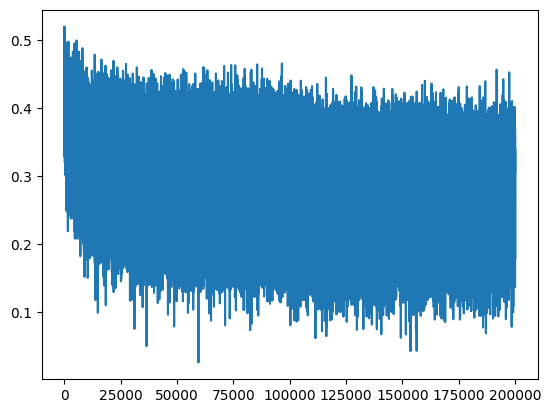

In [22]:
# Initialize parameters with BatchNorm
g = torch.Generator().manual_seed(2147483647)
C = torch.randn((27, 10), generator=g)
W1 = torch.randn((30, 200), generator=g) * (5/3) / ((30)**0.5) 
# b1 is removed
W2 = torch.randn((200, 27), generator=g) * 0.01
b2 = torch.randn(27, generator=g) * 0

# BatchNorm parameters
bngain = torch.ones((1, 200))
bnbias = torch.zeros((1, 200))
bnmean_running = torch.zeros((1, 200))
bnstd_running = torch.ones((1, 200))

parameters = [C, W1, W2, b2, bngain, bnbias]
for p in parameters: p.requires_grad = True

# Training loop
max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps):
  
  # minibatch construct
  ix = torch.randint(0, Xtr.shape[0], (batch_size,))
  Xb, Yb = Xtr[ix], Ytr[ix] # batch X,Y
  
  # forward pass
  emb = C[Xb] # embed the characters into vectors
  embcat = emb.view(emb.shape[0], -1) # concatenate the vectors
  # Linear layer
  hpreact = embcat @ W1 # + b1 # hidden layer pre-activation
  
  # BatchNorm layer
  # -------------------------------------------------------------
  bnmeani = hpreact.mean(0, keepdim=True)
  bnstdi = hpreact.std(0, keepdim=True)
  hpreact = bngain * (hpreact - bnmeani) / bnstdi + bnbias
  
  with torch.no_grad():
    bnmean_running = 0.999 * bnmean_running + 0.001 * bnmeani
    bnstd_running = 0.999 * bnstd_running + 0.001 * bnstdi
  # -------------------------------------------------------------
  
  h = torch.tanh(hpreact) # hidden layer
  logits = h @ W2 + b2 # output layer
  loss = F.cross_entropy(logits, Yb) # loss function
  
  # backward pass
  for p in parameters:
    p.grad = None
  loss.backward()
  
  # update
  lr = 0.1 if i < 100000 else 0.01 # step learning rate decay
  for p in parameters:
    p.data += -lr * p.grad

  # track stats
  if i % 10000 == 0: # print every once in a while
    print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
  lossi.append(loss.log10().item())
  
plt.plot(lossi)

In [23]:
# Calibrate the batch norm at the end of training (optional, if running stats are not accurate enough)
# with torch.no_grad():
#   emb = C[Xtr]
#   embcat = emb.view(emb.shape[0], -1)
#   hpreact = embcat @ W1 + b1
#   bnmean = hpreact.mean(0, keepdim=True)
#   bnstd = hpreact.std(0, keepdim=True)

@torch.no_grad() # this decorator disables gradient tracking
def split_loss(split):
  x,y = {
    'train': (Xtr, Ytr),
    'val': (Xdev, Ydev),
    'test': (Xte, Yte),
  }[split]
  emb = C[x] # (N, block_size, n_embd)
  embcat = emb.view(emb.shape[0], -1) # concat into (N, block_size * n_embd)
  hpreact = embcat @ W1 # + b1
  # hpreact = bngain * (hpreact - hpreact.mean(0, keepdim=True)) / hpreact.std(0, keepdim=True) + bnbias # batchnorm
  hpreact = bngain * (hpreact - bnmean_running) / bnstd_running + bnbias
  h = torch.tanh(hpreact) # (N, n_hidden)
  logits = h @ W2 + b2 # (N, vocab_size)
  loss = F.cross_entropy(logits, y)
  print(split, loss.item())

split_loss('train')
split_loss('val')

train 1.8096908330917358
val 2.066612482070923
